In [2]:
import sys
sys.path.append("..")

from clip_index.image import create_item_comp_dict, build_image_index
from clip_index.utils import create_index
from clip_index.text import run_queries
from annoy import AnnoyIndex

In [3]:
import json
with open('../assets/tiny-imagenet/dataset_infos.json', 'r') as f:
    dataset_infos = json.load(f)
    imagenet_names = dataset_infos['Maysee--tiny-imagenet']['features']['label']['names']

with open('../assets/tiny-imagenet/classes.json', 'r') as f:
    classes = json.load(f)

imagenet_class_labels = list(map(lambda name: classes[name], imagenet_names))
imagenet_class_labels[:10]

['goldfish, Carassius auratus',
 'European fire salamander, Salamandra salamandra',
 'bullfrog, Rana catesbeiana',
 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 'American alligator, Alligator mississipiensis',
 'boa constrictor, Constrictor constrictor',
 'trilobite',
 'scorpion',
 'black widow, Latrodectus mactans',
 'tarantula']

In [4]:
from datasets.load import load_dataset
tiny_imagenet = load_dataset('Maysee/tiny-imagenet', split='train')
labels = tiny_imagenet['label']
images = tiny_imagenet['image']

Using custom data configuration Maysee--tiny-imagenet-35af7c46a941f08e
Found cached dataset parquet (/Users/tom/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


number of elements: 100000, number of labels: 200
label: goldfish, Carassius auratus


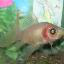

label: European fire salamander, Salamandra salamandra


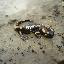

label: bullfrog, Rana catesbeiana


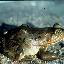

label: tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui


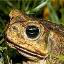

label: American alligator, Alligator mississipiensis


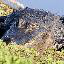

label: boa constrictor, Constrictor constrictor


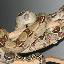

label: trilobite


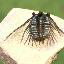

label: scorpion


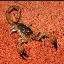

label: black widow, Latrodectus mactans


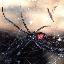

label: tarantula


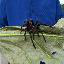

In [5]:
first_label_index = [labels.index(label) for label in range(200)]
print(f"number of elements: {len(tiny_imagenet)}, number of labels: {len(set(labels))}")
for i, index in enumerate(first_label_index[:10]):
    label = imagenet_class_labels[i]
    img = images[index]
    print(f"label: {label}")
    display(img)


In [6]:
index = create_index()
index.load("../assets/indexes/0.ann")
item_matrix = create_item_comp_dict(index)
sorted_item = sorted(item_matrix[1], key=lambda x: x.dist)
item_matrix


{0: [AnnoyImage(image_id=1, dist=1.4142135381698608, image_path=None),
  AnnoyImage(image_id=2, dist=1.4142135381698608, image_path=None),
  AnnoyImage(image_id=3, dist=1.4142135381698608, image_path=None),
  AnnoyImage(image_id=4, dist=1.4142135381698608, image_path=None),
  AnnoyImage(image_id=5, dist=1.4142135381698608, image_path=None),
  AnnoyImage(image_id=6, dist=1.4142135381698608, image_path=None),
  AnnoyImage(image_id=7, dist=1.4142135381698608, image_path=None),
  AnnoyImage(image_id=8, dist=1.4142135381698608, image_path=None),
  AnnoyImage(image_id=9, dist=1.4142135381698608, image_path=None),
  AnnoyImage(image_id=10, dist=1.4142135381698608, image_path=None),
  AnnoyImage(image_id=11, dist=1.4142135381698608, image_path=None),
  AnnoyImage(image_id=12, dist=1.4142135381698608, image_path=None),
  AnnoyImage(image_id=13, dist=1.4142135381698608, image_path=None),
  AnnoyImage(image_id=14, dist=1.4142135381698608, image_path=None),
  AnnoyImage(image_id=15, dist=1.4142135

In [7]:
# import numpy as np
# np_images = list(map(lambda img: np.array(img),images))

# index_size = 1000

# for i, idx in enumerate(range(0, len(np_images), index_size)):
#     index = build_image_index(create_index(), np_images[idx:idx+index_size])
#     index.save(f'assets/indexes/tiny-imagenet/tiny_imagenet_index_{i}.ann')


In [8]:
import torch
from clip_index.text.query_clip import AnnoyQueries

def query_index_with_offset(
    index_paths: list[str],
    queries: list[str],
    max_results: int = 10,
    threshold: float = torch.inf,
    search_k: int = -1,
) -> AnnoyQueries:
    """This is a modified query_index from index_images.py, with an offset in IDs to 
    account for the fact that the indexes are not one big index.

    Each index has 1000 images, so for the first index, the offset is 0, for the second
    index, the offset is 1000, and so on.
    """
    index = create_index()
    query_image_dict: AnnoyQueries = {}
    for i, path in enumerate(index_paths):
        index.load(path)
        new_qs = run_queries(
            index,
            queries,
            max_results=max_results,
            threshold=threshold,
            search_k=search_k,
        )
        for k, v in new_qs.items():
            for img in v: # New changes
                img.image_id += i * 1000
            if k in query_image_dict:
                query_image_dict[k].extend(v)
            else:
                query_image_dict[k] = v
    return query_image_dict

In [12]:
import torch
from pathlib import Path
import os

index_folder = Path('../assets/indexes/tiny-imagenet')

queries = {"goldfish, Carassius auratus": "a photo of a goldfish", "dumbbell": "a photo of a dumbbell"}

query_res = query_index_with_offset(
    index_paths=[str(index_folder / file) for file in os.listdir(index_folder)],
    queries=list(queries.values()),
    max_results=len(images),
    threshold=torch.inf,
    search_k=-1
)

query_res = dict(zip(queries.keys(), query_res.values()))

query: goldfish, Carassius auratus
Top 5
annoy_id: 69938, label: 139, class: sombrero, dist: 0.9580748677253723


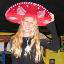

annoy_id: 13222, label: 26, class: standard poodle, dist: 1.0067423582077026


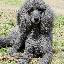

annoy_id: 43780, label: 87, class: crane, dist: 1.0255777835845947


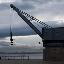

annoy_id: 69761, label: 139, class: sombrero, dist: 1.0486189126968384


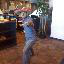

annoy_id: 69513, label: 139, class: sombrero, dist: 1.0492867231369019


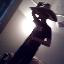



Correct Top 5
annoy_id: 281, label: 0, class: goldfish, Carassius auratus, dist: 1.2223988771438599


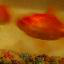

annoy_id: 94, label: 0, class: goldfish, Carassius auratus, dist: 1.2454534769058228


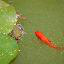

annoy_id: 494, label: 0, class: goldfish, Carassius auratus, dist: 1.2538355588912964


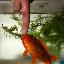

annoy_id: 25, label: 0, class: goldfish, Carassius auratus, dist: 1.2538700103759766


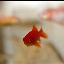

annoy_id: 256, label: 0, class: goldfish, Carassius auratus, dist: 1.2569613456726074


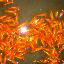


----------------

query: dumbbell
Top 5
annoy_id: 8332, label: 16, class: American lobster, Northern lobster, Maine lobster, Homarus americanus, dist: 0.9539990425109863


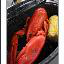

annoy_id: 15721, label: 31, class: lion, king of beasts, Panthera leo, dist: 0.964691698551178


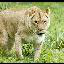

annoy_id: 48836, label: 97, class: fur coat, dist: 0.9705012440681458


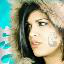

annoy_id: 15870, label: 31, class: lion, king of beasts, Panthera leo, dist: 0.9706632494926453


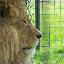

annoy_id: 76958, label: 153, class: tractor, dist: 0.9708409905433655


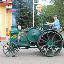



Correct Top 5
annoy_id: 45781, label: 91, class: dumbbell, dist: 1.1156888008117676


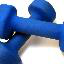

annoy_id: 45695, label: 91, class: dumbbell, dist: 1.1301665306091309


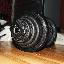

annoy_id: 45913, label: 91, class: dumbbell, dist: 1.1368662118911743


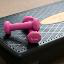

annoy_id: 45630, label: 91, class: dumbbell, dist: 1.1570684909820557


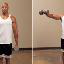

annoy_id: 45535, label: 91, class: dumbbell, dist: 1.1669931411743164


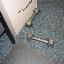


----------------


As you can see, it really does not perform well on this dataset :) however the resolution of these images are alot smaller than the model input, 75x75 v 235x235
This is actually quite an interesting result, in cropping scenarios I may try to keep the images at least at 235 by not allowing cropping any smaller than that

Whats strange is that the top 5 all change on every run?? I don't think the model has any understanding with these images more than throwing darts at a board



In [13]:
for q, imgs in query_res.items():
    print(f"query: {q}")
    imgs.sort(key=lambda x: x.dist)
    correct_label = imagenet_class_labels.index(q)
    correct_queries = list(filter(lambda x: labels[x.image_id] == correct_label, imgs))
    incorrect_queries = list(filter(lambda x: labels[x.image_id] != correct_label, imgs))
    print("Top 5")
    for img in imgs[:5]:
        label = labels[img.image_id]
        cls = imagenet_class_labels[label]
        print(f"annoy_id: {img.image_id}, label: {label}, class: {cls}, dist: {img.dist}")
        display(images[img.image_id])
    print("\n")
    print("Correct Top 5")
    for img in correct_queries[:5]:
        label = labels[img.image_id]
        cls = imagenet_class_labels[label]
        print(f"annoy_id: {img.image_id}, label: {label}, class: {cls}, dist: {img.dist}")
        display(images[img.image_id])
    print("\n----------------\n")

print("""
As you can see, it really does not perform well on this dataset :) however the resolution of these images are alot smaller than the model input, 75x75 v 235x235
This is actually quite an interesting result, in cropping scenarios I may try to keep the images at least at 235 by not allowing cropping any smaller than that

Whats strange is that the top 5 all change on every run?? I don't think the model has any understanding with these images more than throwing darts at a board
""")